In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import random
import cv2
import tensorflow as tf
import time
import random
from pathlib import Path

from tensorflow.keras import datasets, layers, models,applications,losses,optimizers,metrics,Model,backend

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import resnet,Xception

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


tf.__version__, np.__version__
target_shape = (200, 200)

In [2]:
!rm -rf /kaggle/working/*

In [3]:
!pip install gdown

In [4]:
!gdown 1WqIhqp9JJ65SZPs9v868P_-SBCVTR2By

Downloading...
From: https://drive.google.com/uc?id=1WqIhqp9JJ65SZPs9v868P_-SBCVTR2By
To: /kaggle/working/CV_2023_SC_Dataset.zip
100%|███████████████████████████████████████| 1.20M/1.20M [00:00<00:00, 128MB/s]


In [5]:
!pwd

/kaggle/working


In [ ]:
!unzip /kaggle/working/CV_2023_SC_Dataset.zip -d /kaggle/working/data

Making every train and test together 

In [7]:
import os
persons = ['A','B','C','D','E']
os.mkdir('/kaggle/working/Train')
os.mkdir('/kaggle/working/Test')
for p in persons:
    os.mkdir('/kaggle/working/Train/person'+p)
    os.mkdir('/kaggle/working/Test/person'+p)
    

In [8]:
import shutil
import os
import glob
for p in os.listdir('data'):
  print(p)
  for f in os.listdir(f'data/{p}'):
    for d in glob.glob(f'/kaggle/working/data/{p}/{f}/*'):
      shutil.move(d,f'/kaggle/working/{f}/{p}')

personD
personA
personE
personB
personC


Putting DataFrames together

In [9]:
persons = ['A','B','C','D','E']
df = pd.DataFrame()
for person in  persons:
  path = f'/kaggle/working/Train/person{person}/person{person}_SigVerificationTrainLabels.csv'
  tempdf = pd.read_csv(path)
  tempdf['person'] = person
  df = df.append(tempdf)

In [172]:
os.listdir('Test/personA')

['personA_SigVerificationTestLabels.csv',
 'personA_30.png',
 'personA_13.png',
 'personA_2.png',
 'personA_27.png',
 'personA_20.png',
 'personA_10.png',
 'personA_29.png',
 'personA_42.png']

In [173]:
alldf=pd.DataFrame()
for person in  persons:
  path = f'/kaggle/working/Train/person{person}/person{person}_SigVerificationTrainLabels.csv'
  path2 = f'/kaggle/working/Test/person{person}/person{person}_SigVerificationTestLabels.csv'
  tempdf = pd.read_csv(path)
  tempdf2 = pd.read_csv(path2)
  tempdf['person'] = person
  tempdf2['person'] = person
  alldf = alldf.append(tempdf)  
  alldf = alldf.append(tempdf2)

In [10]:
df.head()

,image_name,label,person
0,personA_37.png,forged,A
1,personA_3.png,forged,A
2,personA_28.png,forged,A
3,personA_31.png,forged,A
4,personA_48.png,forged,A


In [11]:
forged = []
real = []
tripletList = []
forged = df[df["label"]=="forged"]
real = df[df.label=="real"]

In [12]:
forged.head()

,image_name,label,person
0,personA_37.png,forged,A
1,personA_3.png,forged,A
2,personA_28.png,forged,A
3,personA_31.png,forged,A
4,personA_48.png,forged,A


In [13]:
def create_triplets(real,fake, max_files=10):
    triplets = []
    a = 0
    for person in real["person"].unique():
      for i in range(len(real[real["person"]==person])-1):
        for j in range(i+1,len(real[real["person"]==person])):
            anchor = real.iloc[(i+a)%(len(real)-1)]["image_name"]
            positive = real.iloc[(j+a)%(len(real)-1)]["image_name"]
            negative = fake.iloc[(j+a)%(len(real)-1)]["image_name"]    
            triplets.append((anchor,positive,negative))
      a = a+40
            
    random.shuffle(triplets)
    return triplets

In [14]:
os.mkdir('/kaggle/working/allImages')

In [15]:
for p in os.listdir('Test'):
  print(p)
  for d in glob.glob(f'/kaggle/working/Train/{p}/*.png'):
    shutil.copy(d,f'/kaggle/working/allImages/')

personD
personA
personE
personB
personC


In [16]:
for p in os.listdir('Test'):
  print(p)
  for d in glob.glob(f'/kaggle/working/Test/{p}/*.png'):
    shutil.copy(d,f'/kaggle/working/allImages')

personD
personA
personE
personB
personC


In [66]:
ROOT = '/kaggle/working/allImages'
def read_image(index):
    path = os.path.join(ROOT, index)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128)) 
    return image


In [103]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        h=0
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            a=read_image(a)
            p=read_image(p)
            n=read_image(n)
            anchor.append(preprocess_input(a))
            positive.append(preprocess_input(p))
            negative.append(preprocess_input(n))
            h+=1
            j+=1
        print(h)
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
#         if preprocess:
#             anchor = preprocess_input(anchor)
#             positive = preprocess_input(positive)
#             negative = preprocess_input(negative)
    yield ([anchor, positive, negative])        


In [19]:
import warnings;warnings.filterwarnings('ignore')

In [20]:
trip = create_triplets(real,forged)

In [21]:
#  for data in get_batch(trip[0:5], batch_size=2):
#         a=data
#         #a=data[0][0]
#         print(a)
#         break

In [22]:
trip = create_triplets(real,forged)

In [23]:
trip[33]

('personC_30.png', 'personC_33.png', 'personC_11.png')

put all images together

In [24]:
# def preprocess_image(filename):
#     """
#     Load the specified file as a JPEG image, preprocess it and
#     resize it to the target shape.
#     """

#     image_string = tf.io.read_file(filename)
#     image = tf.image.decode_png(image_string, channels=3)
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, target_shape)
#     return image


# def preprocess_triplets(anchor, positive, negative):
#     """
#     Given the filenames corresponding to the three images, load and
#     preprocess them.
#     """

#     return (
#         preprocess_image(anchor),
#         preprocess_image(positive),
#         preprocess_image(negative),
#     )

In [25]:
# anchorImages = []
# positiveImages = []
# negativeImages = []
# tripImages = []
# for images in trip:
#   tripImages.append(preprocess_triplets("/kaggle/working/allImages/"+images[0],"/kaggle/working/allImages/"+images[1],"/kaggle/working/allImages/"+images[2]))

# for images in tripImages:
#   anchorImages.append(images[0])
#   positiveImages.append(images[1])
#   negativeImages.append(images[2])

In [26]:
# anchorImages[0][2]==anchorImages[0][3]

In [27]:
# anchor_dataset = tf.data.Dataset.from_tensor_slices(anchorImages)
# positive_dataset = tf.data.Dataset.from_tensor_slices(positiveImages)
# negative_dataset = tf.data.Dataset.from_tensor_slices(negativeImages)
# #negative_dataset = negative_dataset.shuffle(buffer_size=4096)

# dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
# dataset = dataset.shuffle(buffer_size=1024)
# #dataset = dataset.map(preprocess_triplets)

# # Let's now split our dataset in train and validation.
# train_dataset = dataset.take(round(len(anchorImages) * 0.8))
# val_dataset = dataset.skip(round(len(anchorImages) * 0.8))

# train_dataset = train_dataset.batch(32, drop_remainder=False)
# train_dataset = train_dataset.prefetch(8)

# val_dataset = val_dataset.batch(32, drop_remainder=False)
# val_dataset = val_dataset.prefetch(8)

In [28]:
# print(dataset)

In [29]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])




In [30]:
# base_cnn = resnet.ResNet50(
#     weights="imagenet", input_shape=target_shape + (3,), include_top=False
# )

# flatten = layers.Flatten()(base_cnn.output)
# dense1 = layers.Dense(512, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(256, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)
# output = layers.Dense(256)(dense2)

# embedding = Model(base_cnn.input, output, name="Embedding")
# # for transfer learning we make the first layers weights untrianable except the last layer 
# # which is Conv5 in resnet doc (https://arxiv.org/pdf/1512.03385.pdf)
# trainable = False
# for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":
#         trainable = True
#     layer.trainable = trainable

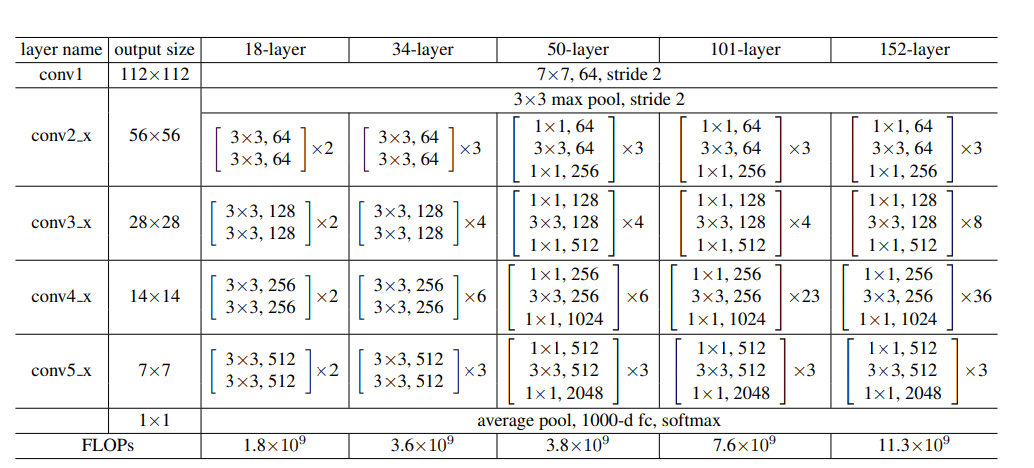

In [31]:
# sample = next(iter(train_dataset))
# visualize(*sample)

# anchor, positive, negative = sample
# anchor_embedding, positive_embedding, negative_embedding = (
#     embedding(resnet.preprocess_input(anchor)),
#     embedding(resnet.preprocess_input(positive)),
#     embedding(resnet.preprocess_input(negative)),
# )

In [32]:
# visualize(anchorImages[0:3],positiveImages[0:3],negativeImages[0:3])

Setting up the embedding generator model (encoder)

# Setting up the Siamese Network model
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

In [33]:
# class DistanceLayer(layers.Layer):
#     """
#     This layer is responsible for computing the distance between the anchor
#     embedding and the positive embedding, and the anchor embedding and the
#     negative embedding.
#     """

#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def call(self, anchor, positive, negative):
#         ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
#         an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
#         return (ap_distance, an_distance)


In [34]:
# anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
# positive_input = layers.Input(name="positive", shape=target_shape + (3,))
# negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# distances = DistanceLayer()(
#     embedding(resnet.preprocess_input(anchor_input)),
#     embedding(resnet.preprocess_input(positive_input)),
#     embedding(resnet.preprocess_input(negative_input)),
# )

# siamese_network = Model(
#     inputs=[anchor_input, positive_input, negative_input], outputs=distances)

We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

In [35]:
# class SiameseModel(Model):
#     """The Siamese Network model with a custom training and testing loops.

#     Computes the triplet loss using the three embeddings produced by the
#     Siamese Network.

#     The triplet loss is defined as:
#        L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
#     """

#     def __init__(self, siamese_network, margin=0.5):
#         super(SiameseModel, self).__init__()
#         self.siamese_network = siamese_network
#         self.margin = margin
#         self.loss_tracker = metrics.Mean(name="loss")

#     def call(self, inputs):
#         return self.siamese_network(inputs)

#     def train_step(self, data):
#         # GradientTape is a context manager that records every operation that
#         # you do inside. We are using it here to compute the loss so we can get
#         # the gradients and apply them using the optimizer specified in
#         # `compile()`.
#         with tf.GradientTape() as tape:
#             loss = self._compute_loss(data)

#         # Storing the gradients of the loss function with respect to the
#         # weights/parameters.
#         gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

#         # Applying the gradients on the model using the specified optimizer
#         self.optimizer.apply_gradients(
#             zip(gradients, self.siamese_network.trainable_weights)
#         )

#         # Let's update and return the training loss metric.
#         self.loss_tracker.update_state(loss)
#         return {"loss": self.loss_tracker.result()}

#     def test_step(self, data):
#         loss = self._compute_loss(data)

#         # Let's update and return the loss metric.
#         self.loss_tracker.update_state(loss)
#         return {"loss": self.loss_tracker.result()}

#     def _compute_loss(self, data):
#         # The output of the network is a tuple containing the distances
#         # between the anchor and the positive example, and the anchor and
#         # the negative example.
#         ap_distance, an_distance = self.siamese_network(data)

#         # Computing the Triplet Loss by subtracting both distances and
#         # making sure we don't get a negative value.
#         loss = ap_distance - an_distance
#         loss = tf.maximum(loss + self.margin, 0.0)
#         return loss

#     @property
#     def metrics(self):
#         # We need to list our metrics here so the `reset_states()` can be
#         # called automatically.
#         return [self.loss_tracker]

In [36]:
# siamese_model = SiameseModel(siamese_network)
# siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [37]:
# siamese_model.fit(train_dataset,epochs=10,validation_data=val_dataset)

In [38]:
# anchorImages[0].shape

In [39]:
# sample = next(iter(train_dataset))
# visualize(*sample)

# anchor, positive, negative = sample
# anchor_embedding, positive_embedding, negative_embedding = (
#     embedding(resnet.preprocess_input(anchor)),
#     embedding(resnet.preprocess_input(positive)),
#     embedding(resnet.preprocess_input(negative)),
# )

In [40]:
# cosine_similarity = metrics.CosineSimilarity()

# positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
# print("Positive similarity:", positive_similarity.numpy())

# negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
# print("Negative similarity", negative_similarity.numpy())

In [41]:
# siamese_model.predict((anchorImages[0],positiveImages[0],negativeImages[0]))

# Siames i hope

In [42]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [43]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

2022-12-22 20:33:25.831952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 20:33:25.842880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 20:33:25.843595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 20:33:25.845278: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

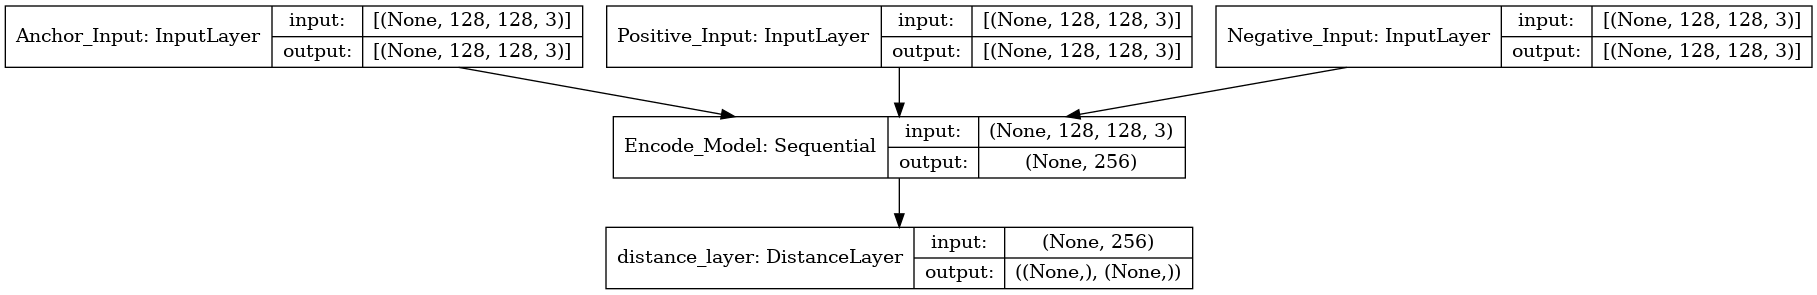

In [44]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [45]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [46]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [47]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [48]:
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
rng = RandomState()
trainreal, testreal = train_test_split(real, test_size=0.3)
trainfake, testfake = train_test_split(forged, test_size=0.3)

In [49]:
train_triplet = create_triplets(trainreal,trainfake)
test_triplet = create_triplets(testreal,testfake)

In [50]:
testreal.head()

,image_name,label,person
32,personE_48.png,real,E
39,personB_19.png,real,B
27,personB_23.png,real,B
31,personC_25.png,real,C
20,personE_34.png,real,E


In [51]:
train_triplet[0:5]

[('personE_3.png', 'personD_2.png', 'personB_31.png'),
 ('personC_47.png', 'personD_18.png', 'personC_23.png'),
 ('personD_40.png', 'personA_17.png', 'personE_24.png'),
 ('personE_4.png', 'personE_21.png', 'personB_48.png'),
 ('personA_43.png', 'personB_43.png', 'personD_32.png')]

In [53]:
save_all = False
epochs = 50
batch_size = 258

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        print(1)
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")

1

EPOCH: 1 	 (Epoch done in 9 sec)
Loss on train    = 0.71034
Accuracy on test = 0.81395
1

EPOCH: 2 	 (Epoch done in 5 sec)
Loss on train    = 0.62739
Accuracy on test = 0.87209
1

EPOCH: 3 	 (Epoch done in 4 sec)
Loss on train    = 0.40047
Accuracy on test = 0.68605
1

EPOCH: 4 	 (Epoch done in 4 sec)
Loss on train    = 0.68049
Accuracy on test = 0.88372
1

EPOCH: 5 	 (Epoch done in 5 sec)
Loss on train    = 0.21361
Accuracy on test = 0.88372
1

EPOCH: 6 	 (Epoch done in 4 sec)
Loss on train    = 0.25844
Accuracy on test = 0.93023
1

EPOCH: 7 	 (Epoch done in 5 sec)
Loss on train    = 0.11123
Accuracy on test = 0.83721
1

EPOCH: 8 	 (Epoch done in 4 sec)
Loss on train    = 0.15171
Accuracy on test = 0.93023
1

EPOCH: 9 	 (Epoch done in 4 sec)
Loss on train    = 0.05603
Accuracy on test = 0.88372
1

EPOCH: 10 	 (Epoch done in 4 sec)
Loss on train    = 0.10723
Accuracy on test = 0.97674
1

EPOCH: 11 	 (Epoch done in 4 sec)
Loss on train    = 0.02432
Accuracy on test = 0.95349
1

EPOCH

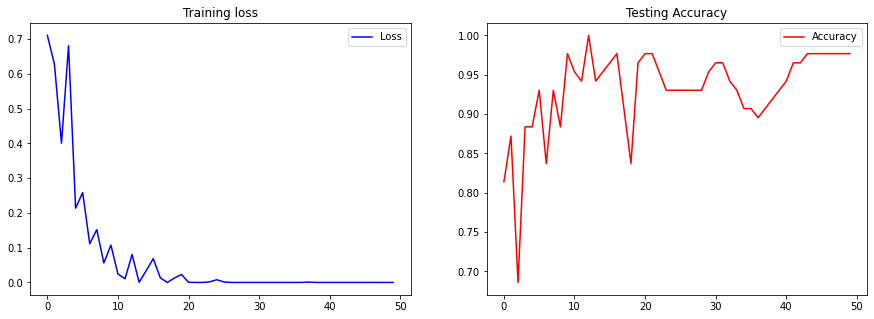

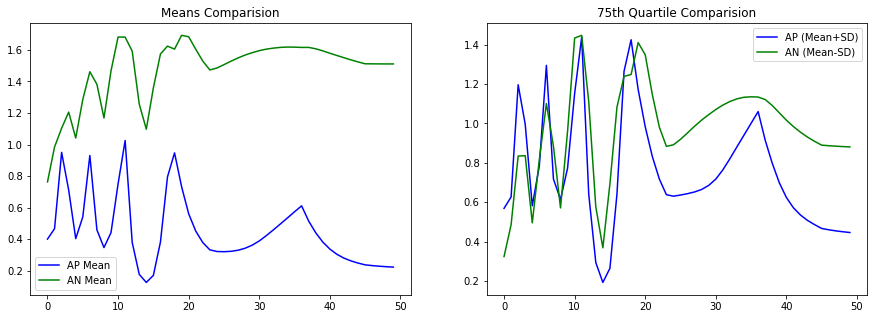

In [54]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [55]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
__________________________________

In [56]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.8333333333333334



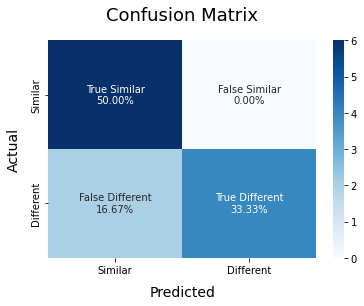

In [57]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=8):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [ ]:
a=[i[0] for i in trip]
p=[i[1] for i in trip]

In [104]:
pos_list=[]
neg_list=[]
for data in get_batch(test_triplet, batch_size=500):
    a, p, n = data
    print(a.shape)
    pos_list = np.append(pos_list, classify_images(a, p))

    neg_list = np.append(neg_list, classify_images(a, n))

86
(86, 128, 128, 3)


In [ ]:
test_triplet

In [110]:
lst=[]
image = read_image('personB_28.png')
image = preprocess_input(image)
lst.append(image)
lst=np.array(lst)
for data in get_batch(test_triplet, batch_size=500):
    a, p, n = data
    a=lst
    pos_list = np.append(pos_list, classify_images(a, p))

    neg_list = np.append(neg_list, classify_images(a, n))
    


86


In [ ]:
pos_list

In [ ]:
neg_list

In [118]:
for index, row in df.iterrows():
    print(row)
    break

image_name    personA_37.png
label                 forged
person                     A
Name: 0, dtype: object


In [ ]:
forged

In [178]:
def findSimilar(img,thres=0.06):
    a=read_image(img)
    a=preprocess_input(a)
    lst=[a]
    lst=np.array(lst)
    xx=[]
    for index, row in alldf.iterrows():
        dfimg = read_image(row['image_name'])
        dfimg = preprocess_input(dfimg)
        dfimg = np.array([dfimg])
        x=classify_images(lst,dfimg,thres)
        if x ==0: xx.append(row['label'])
    return xx

In [179]:
alldf.query('image_name.str.contains("personD_31")', engine='python')

,image_name,label,person
4,personD_31.png,real,D


In [183]:
findSimilar('personA_33.png')

['forged', 'forged']